<a href="https://colab.research.google.com/github/huertaj2/vgchartz-analysis/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Capstone for Jacob Huerta, January 2022**

**Overview**

This project is a self-driven, beginning to end analysis of video game sales data. The project proposal is [here](https://docs.google.com/document/d/1jOY6351Ut2G-JyoFCNDj3jQTjyMydwdkip1dXUupM8w/edit?usp=sharing); in order to keep this Notebook tidy I will not recap what is in the proposal. 

**Section 1: Importing Data**

Note that this script is a [fork](https://github.com/huertaj2/vgchartzScrape/) from the original so that we can scrape specific release days, not just years. This requires parsing the whole script and modifying the sections that deal with the date, which I did myself. Because the format of the date on vgcharts is e.g. "25th Jun 89", I had to do some parsing and cleaning to get it into a machine-readable state. I edited lines 84 through 104 as well as a few small other changes. I included an example of the section I changed below. This is a self contained code block and does not need to be run to execute the rest of those workbook.

In [ ]:
import datetime as dt
#create mock lists for the date based on original script
date=[]
#create example release date, formatted as list based on original script
release_date = ["25th", "Jun", "89"]
#format for entries that do not have a release date
if release_date[0] == 'N/A':
            date.append('N/A')
else:
            day = release_date[0]
            #remove th, st, nd, etc:
            day = day[0:2]
            year = release_date[2]
            #format year as 4 digit number
            if int(year) >= 80:
                year = 1900 + int(year)
            else:
                year = 2000 + int(year)
            #turn pieces back into string
            date_to_add = '{}/{}/{}'.format(day, release_date[1], year)
            #format as datetime
            d= dt.datetime.strptime(date_to_add, "%d/%b/%Y")
            print(d)
            

1989-06-25 00:00:00


After I reworked this section of code, of course, I discovered more fundamental issues with the data source. The website has changed formats over the years since this scraper was first written, and SSL (encrypted browsing) has become the norm. I spent a significant amount of time experimenting with the scraper and working on github to find other forks that had fixed problems that cropped up.

As part of this process, I discovered that vgchartz stopped making software sales estimates as of 2018. As a result, I have decided to change the scope of this project slightly. Rather than focus on pandemic-related sales changes, I am going to focus on other trends. Even though I was able to get the scraper running properly and downloaded a few different versions of the dataset from vgchartz, for this project I will use the dataset from Kaggle, as the process of scraping Genre tags in particular is extremely time consuming and they are already included in the Kaggle set. We will focus on Global Sales.

# Revised Hyotheses

H1a: There is a statistically significant increase in the sales of Sports games in 2015 vs 2005. Sports games have moved to annual releases in many series, and I expect the plethora of options available in more recent years have increased sales.

H10: There is no statistical significance in Sports game sales between 2015 and 2005.

H2a: There is a statistically significant increase in PC game sales in 2008 vs 2012. Minecraft was released in 2011, and it proved to be so popular that I expect PC gaming took off as a result.

H20: There is no statistically significant change in PC game sales in 2010 vs 2015.


Bonus: I'm also interested in comparing all sales of games for PC vs all consoles.
# Initial Analysis

To begin, I will import relevant libraries, import the dataset as a DataFrame, look at the overall shape and contents. Then I will do some basic cleaning.

In [ ]:
#import libraries
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns 
sns.set()
from scipy import stats
import numpy as np
import random
#format access to dataset
url='https://raw.githubusercontent.com/huertaj2/Capstone-Project/main/vgsales.csv'
df = pd.read_csv(url)
#old way of reading from gdrive:
#from google.colab import drive
#drive.mount('/content/gdrive')
#df = pd.read_csv('/content/gdrive/My Drive/Dataset/vgsales.csv')



In [ ]:
#look at basic dataset information
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [ ]:
#get null count for crucial columns
print(df['Global_Sales'].isnull().sum())
print(df['Genre'].isnull().sum())
print(df['Platform'].isnull().sum())
print(df['Year'].isnull().sum())

0
0
0
271


Since we have some null years, and we need to filter by year, we will drop game listings that have a null year.

In [ ]:
#drop games with n/a (0) as the year:
df = df.dropna(subset=['Year'])
df.info()
print(df['Year'].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16327 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16327 non-null  int64  
 1   Name          16327 non-null  object 
 2   Platform      16327 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16327 non-null  object 
 5   Publisher     16291 non-null  object 
 6   NA_Sales      16327 non-null  float64
 7   EU_Sales      16327 non-null  float64
 8   JP_Sales      16327 non-null  float64
 9   Other_Sales   16327 non-null  float64
 10  Global_Sales  16327 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB
0


In [ ]:
#get unique count for relevant columns
print(df['Genre'].nunique())
print(df['Platform'].nunique())

12
31


In [ ]:
#drop columns we don't need, for efficiency's sake
labels= ['Rank', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Publisher', 'NA_Sales']
df=df.drop(labels, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16327 entries, 0 to 16597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16327 non-null  object 
 1   Platform      16327 non-null  object 
 2   Year          16327 non-null  float64
 3   Genre         16327 non-null  object 
 4   Global_Sales  16327 non-null  float64
dtypes: float64(2), object(3)
memory usage: 765.3+ KB


In [ ]:
#convert year to integer
df['Year'] = df['Year'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16327 entries, 0 to 16597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16327 non-null  object 
 1   Platform      16327 non-null  object 
 2   Year          16327 non-null  int64  
 3   Genre         16327 non-null  object 
 4   Global_Sales  16327 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 765.3+ KB


In [ ]:
#print unique entries to confirm we have no duplicates or typos, now that we've confirmed there won't be too many entries
print(df['Genre'].unique())
print(df['Platform'].unique())

#add random column for internal testing later
df['Rand']= np.random.randint(0,2,len(df))
df.head()

['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy']
['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' '3DS' 'PS4' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'GC' 'WiiU' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']


,Name,Platform,Year,Genre,Global_Sales,Rand
0,Wii Sports,Wii,2006,Sports,82.74,1
1,Super Mario Bros.,NES,1985,Platform,40.24,0
2,Mario Kart Wii,Wii,2008,Racing,35.82,0
3,Wii Sports Resort,Wii,2009,Sports,33.00,0
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,31.37,0


# Sports Analysis
Arguably, Racing and Sports games could really be considered part of the same genre. As such, rather than having to potentially add the sales from those two categories together multiple times over the course of this analysis, I will add a column that flags if a game is either a Racing or a Sports game, and we will use that column to filter our "Sports" analysis. It doesn't look like we need to do any additional organizing for the "PC" platform. 

For our "bonus" analysis later, we'll need to make a column flagging portable systems, which would be: GB, DS, GBA, 3DS, PSV, and PSP. 

In [ ]:
#create new dataframe:
df_sports=df.copy()
#create new column prefilled with 'False'
df_sports['Sports_and_Racing'] = False
#overwrite column with 'True' where applicable
df_sports.loc[df['Genre'] == 'Sports', 'Sports_and_Racing'] = True
df_sports.loc[df['Genre'] == 'Racing', 'Sports_and_Racing'] = True

In [ ]:
#filter our new dataframe to just include sports and racing games
df_sports=df_sports.loc[df_sports['Sports_and_Racing']==True]
df_sports.head()


,Name,Platform,Year,Genre,Global_Sales,Rand,Sports_and_Racing
0,Wii Sports,Wii,2006,Sports,82.74,1,True
2,Mario Kart Wii,Wii,2008,Racing,35.82,0,True
3,Wii Sports Resort,Wii,2009,Sports,33.00,0,True
11,Mario Kart DS,DS,2005,Racing,23.42,0,True
13,Wii Fit,Wii,2007,Sports,22.72,0,True


In [ ]:
#reset index to actual values
df_sports.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
df_sports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               3530 non-null   object 
 1   Platform           3530 non-null   object 
 2   Year               3530 non-null   int64  
 3   Genre              3530 non-null   object 
 4   Global_Sales       3530 non-null   float64
 5   Rand               3530 non-null   int64  
 6   Sports_and_Racing  3530 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 169.0+ KB


In [ ]:
#create our groups for t-test comparison purposes
df_sports_2005=df_sports.loc[df_sports['Year']==2005]
print(df_sports_2005.info())
df_sports_2015=df_sports.loc[df_sports['Year']==2015]
print(df_sports_2015.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 3 to 3508
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               199 non-null    object 
 1   Platform           199 non-null    object 
 2   Year               199 non-null    int64  
 3   Genre              199 non-null    object 
 4   Global_Sales       199 non-null    float64
 5   Rand               199 non-null    int64  
 6   Sports_and_Racing  199 non-null    bool   
dtypes: bool(1), float64(1), int64(2), object(3)
memory usage: 11.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 81 entries, 14 to 3513
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               81 non-null     object 
 1   Platform           81 non-null     object 
 2   Year               81 non-null     int64  
 3   Genre              81 non-null     o

Now we will run some t-tests. First we should check internal consistency, so we will a-a test using the Rand value as a sorting mechanism. 

In [ ]:
#a-a test with games released in 2005
sports_2005a = df_sports_2005.iloc[(df_sports_2005['Rand'] == 0).values]
sports_2005b = df_sports_2005.iloc[(df_sports_2005['Rand'] == 1).values]
#check group sizes
print(len(sports_2005a))
print(len(sports_2005b))
p=stats.ttest_ind(sports_2005a['Global_Sales'], sports_2005b['Global_Sales'])
if p[1]< .05:
  print("There is a statistically significant difference")
else:
    print("There is not a significant difference") 
print("the p value is ",p[1])
print("the correlation is ", p[0])

107
92
There is not a significant difference
the p value is  0.3098748181446466
the correlation is  1.018109102210859


In [ ]:
#a-a test with games released in 2015
sports_2015a = df_sports_2015.iloc[(df_sports_2015['Rand'] == 0).values]
sports_2015b = df_sports_2015.iloc[(df_sports_2015['Rand'] == 1).values]
#check group sales
print(len(sports_2015a))
print(len(sports_2015b))
p=stats.ttest_ind(sports_2015a['Global_Sales'], sports_2015b['Global_Sales'])
if p[1]< .05:
  print("There is a statistically significant difference")
else:
    print("There is not a significant difference") 
print("the p value is ",p[1])
print("the correlation is ", p[0])

40
41
There is not a significant difference
the p value is  0.5313403366003608
the correlation is  -0.6287288090635827


Now that we've confirmed both categories are internally consistent, we can do our proper comparison. 

In [ ]:
p_sports=stats.ttest_ind(df_sports_2005['Global_Sales'], df_sports_2015['Global_Sales'])
if p_sports[1]< .05:
  print("There is a statistically significant difference")
else:
    print("There is not a significant difference") 
print("the p value is ",p_sports[1])
print("the correlation is ", p_sports[0])


There is not a significant difference
the p value is  0.89772328178943
the correlation is  -0.128655489815919


Looks like there is no statistically significance in sales for these two groups, which means the null hypotheses holds true here. P > .05. Now that we have this information, we can spend some time visualizing what's going on.

[Text(0, 0.5, 'Global Sales (millions)')]

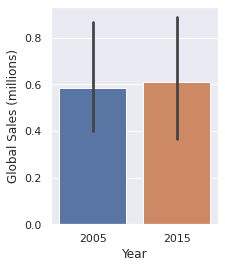

In [ ]:
#combine dataframes for easy graphing:
df_sports_2years=pd.concat([df_sports_2005, df_sports_2015])
#barplots for our two years
f, ax = plt.subplots(figsize=(3, 4))
sports_2005= sns.barplot(x='Year', y='Global_Sales', data=df_sports_2years)
ax.set(ylabel="Global Sales (millions)")

As we can see, these two years are pretty close. What if we look at all the years in between?

[Text(0, 0.5, 'Global Sales (millions)')]

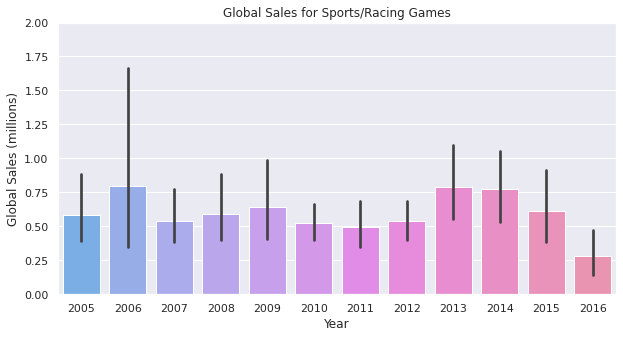

In [ ]:
f, ax = plt.subplots(figsize=(10, 5))
sports_all=sns.barplot(x='Year', y="Global_Sales", data=df_sports).set(title='Global Sales for Sports/Racing Games')
plt.xlim(24.5,36.5)
plt.ylim(0,2)
ax.set(ylabel="Global Sales (millions)")

If we look at bar plots for all of the years of sports/racing sales between our selected years, we can see that there is a great deal of variance but no obvious trend. Most years have a great deal of overlap in the standard confidence interval. 
To further examine any trends for this time period we can look at another graph.

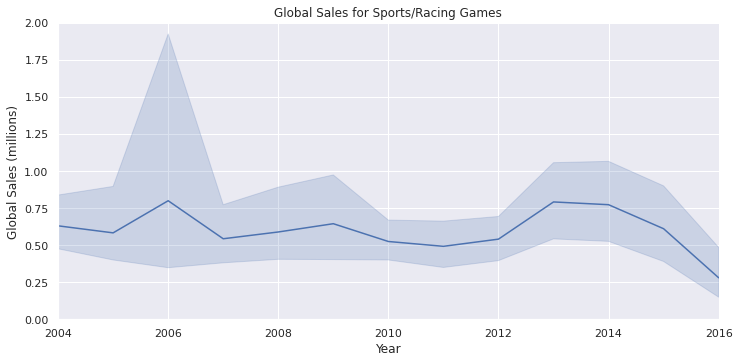

In [ ]:
sports_all_line=sns.relplot(x='Year', y="Global_Sales", data=df_sports, kind='line',aspect=10/5).set(title='Global Sales for Sports/Racing Games')
plt.xlim(2004,2016)
plt.ylim(0,2)
sports_all_line.set_ylabels("Global Sales (millions)", clear_inner=False)

Now we can see a certain ebb and flow of sales without there being any particular trend.



# Part 2: PC Game Sales over time

Now we'll take a look at PC game sales. This analysis can start directly from the original dataframe, filtering as we go.

In [ ]:
#filter to just pc games:
pc_games = df.iloc[(df['Platform'] == 'PC').values]
#filter into two groups, 2008 and 2012:
pc_games_2008 = pc_games.iloc[(pc_games['Year'] == 2008).values]
pc_games_2012 = pc_games.iloc[(pc_games['Year'] == 2012).values]
pc_games_2008.info()
pc_games_2012.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 1486 to 16508
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          76 non-null     object 
 1   Platform      76 non-null     object 
 2   Year          76 non-null     int64  
 3   Genre         76 non-null     object 
 4   Global_Sales  76 non-null     float64
 5   Rand          76 non-null     int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 4.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 181 to 16566
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          61 non-null     object 
 1   Platform      61 non-null     object 
 2   Year          61 non-null     int64  
 3   Genre         61 non-null     object 
 4   Global_Sales  61 non-null     float64
 5   Rand          61 non-null     int64  
dtypes: float64(1), int64(2), objec

Our dataset here is small, and internal consistency isn't particularly relevant at this scale, so we can jump straight to A-B testing:

In [ ]:
#t-test between PC sales in 2008 vs 2012:
p_pc_year=stats.ttest_ind(pc_games_2008['Global_Sales'], pc_games_2012['Global_Sales'])
if p_pc_year[1]< .05:
  print("There is a statistically significant difference")
else:
    print("There is not a significant difference") 
print("the p value is ",p_pc_year[1])
print("the correlation is ", p_pc_year[0])

There is a statistically significant difference
the p value is  0.02766891975087625
the correlation is  -2.226048880296559


We can see here that the P value is close to .05 but not below, so we have a relatively weak difference here. Now, to graph it!


[Text(0, 0.5, 'Global Sales (millions)')]

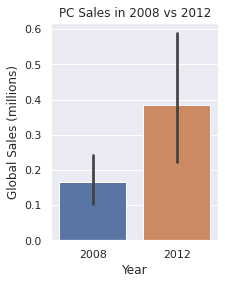

In [ ]:
#combine dataframes for easy graphing:
pc_games_2years=pd.concat([pc_games_2008, pc_games_2012])
#barplots for our two years
f, ax = plt.subplots(figsize=(3, 4))
pc_2years= sns.barplot(x='Year', y='Global_Sales', data=pc_games_2years).set(title='PC Sales in 2008 vs 2012')
ax.set(ylabel="Global Sales (millions)")

Because of our relatively small sample size, the error bars are pretty large here, but we can see see a statistically significant increase in sales. 

We will look at some big picture data in terms of PC vs Console sales over the years in the next section, but we can examine our PC data a little further now:

(0.0, 1.0)

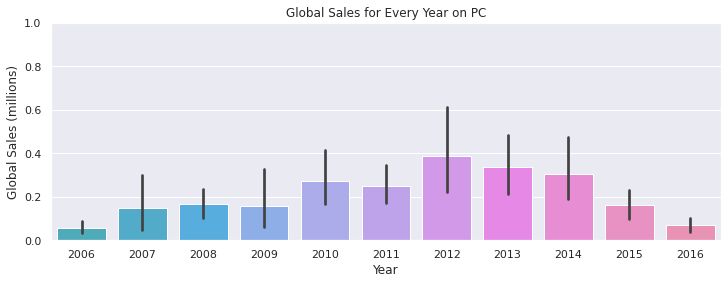

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
pc_years= sns.barplot(x='Year', y='Global_Sales', data=pc_games).set(title='Global Sales for Every Year on PC')
ax.set(ylabel="Global Sales (millions)")
plt.xlim(14.5)
plt.ylim(0,1)

[Text(20.199999999999996, 0.5, 'Global Sales (millions)')]

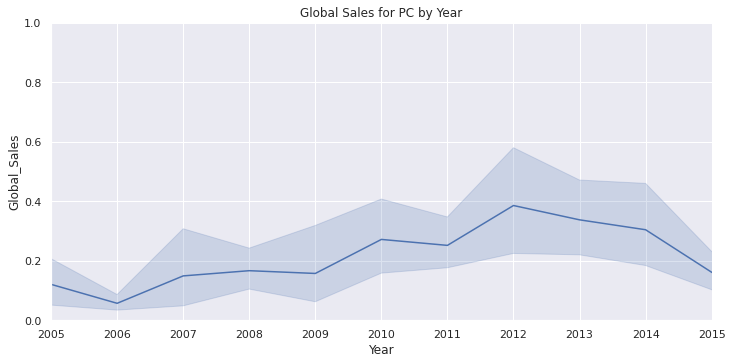

In [ ]:
ticks=[2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
pc_line=sns.relplot(x='Year', y="Global_Sales", data=pc_games, kind='line',aspect=10/5).set(title='Global Sales for PC by Year')
plt.xlim(2005,2015)
plt.xticks(ticks)
plt.ylim(0,1)
ax.set(ylabel="Global Sales (millions)")

Now we can visualize the rise in PC gaming that peaked around 2012.

# Bonus: PC vs Console Games
The setup for this analysis should be simpler, since we can work directly from the original dataframe.

In [ ]:
#set up filtered groups:
pc_games = df.iloc[(df['Platform'] == 'PC').values]
non_pc_games = df.iloc[(df['Platform'] != 'PC').values]
#check group sizes
print(len(pc_games), " game listings for PC")
print(len(non_pc_games), " game listings for non-PC")
#internal a-a testing for PC:
pc_games_a =pc_games.iloc[(pc_games['Rand'] == 0).values]
pc_games_b =pc_games.iloc[(pc_games['Rand'] == 1).values]
print(len(pc_games_a), " game listings for PC group a")
print(len(pc_games_b), " game listings for PC group b")
a=stats.ttest_ind(pc_games_a['Global_Sales'], pc_games_b['Global_Sales'])
print("T-test results for a-a PC group testing: ", a)
#internal a-a testing for not PC:
non_pc_games_a =non_pc_games.iloc[(non_pc_games['Rand'] == 0).values]
non_pc_games_b =non_pc_games.iloc[(non_pc_games['Rand'] == 1).values]
print(len(non_pc_games_a), " game listings for non-PC group a")
print(len(non_pc_games_b), " game listings for non-PC group b")
b=stats.ttest_ind(non_pc_games_a['Global_Sales'], non_pc_games_b['Global_Sales'])
print("T-test results for a-a non-PC group testing: ", b)

if a[1] > .05:
  if b[1] >.05:
    print("Both groups are internally consistent")
  else:
      print('One or Both groups are not internally consistent')
else:
  print('One or Both groups are not internally consistent')
#stats.ttest_ind(group1['Global_Sales'], group2['Global_Sales'])


943  game listings for PC
15384  game listings for non-PC
477  game listings for PC group a
466  game listings for PC group b
T-test results for a-a PC group testing:  Ttest_indResult(statistic=0.3956395553372786, pvalue=0.6924606313393289)
7744  game listings for non-PC group a
7640  game listings for non-PC group b
T-test results for a-a PC group testing:  Ttest_indResult(statistic=1.0175042084723107, pvalue=0.30892963465495404)
Both groups are internally consistent


Because non-PC games encompass such a wide variety, there can be a lot of variability within that group. So it is not surprising that the P-value for the internal non-PC t-test is lower.

In [ ]:
#t-test between PC and not PC groups:
p_pc_console=stats.ttest_ind(pc_games['Global_Sales'], non_pc_games['Global_Sales'])
if p_pc_console[1]< .05:
  print("There is a statistically significant difference")
else:
    print("There is not a significant difference") 
print("the p value is ",p_pc_console[1])
print("the correlation is ", p_pc_console[0])

There is a statistically significant difference
the p value is  4.958040170948757e-08
the correlation is  -5.4553760691812565


As we can see, there is a significant difference in these two groupings. Let's look at some visualizations to get a better idea of the difference.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0, 0.5, 'Global Sales (millions)')]

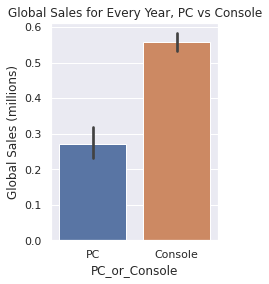

In [ ]:
#add tag to non-pc games for sorting:
pc_games['PC_or_Console'] = "PC"
non_pc_games['PC_or_Console'] = "Console"
#combine dataframes for easy graphing:
pc_or_console=pd.concat([pc_games, non_pc_games])
#barplots for our two years
f, ax = plt.subplots(figsize=(3, 4))
pc_or_console_bar= sns.barplot(x='PC_or_Console', y='Global_Sales', data=pc_or_console).set(title='Global Sales for Every Year, PC vs Console')
ax.set(ylabel="Global Sales (millions)")

We can look at this same comparison year by year, using color as a differentiator:

(0.0, 1.0)

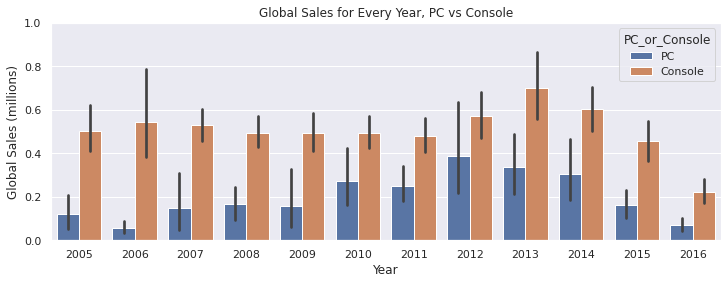

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))
pc_vs_console_year= sns.barplot(x='Year', y='Global_Sales', hue='PC_or_Console', data=pc_or_console).set(title='Global Sales for Every Year, PC vs Console')
ax.set(ylabel="Global Sales (millions)")
plt.xlim(24.5,36.5)
plt.ylim(0,1)

This provides some very useful information, in that we can see an uptick in PC gaming around 2012 (which was when many blockbuster PC games were released), and a separate peak in non-PC gaming in 2013. Some of the reduction in numbers towards the end of this time period could actually be ascribed to digital-only sales, as vgchartz has stated they had difficulty making estimates for those sales.
This may be easier to visualize in a line graph or a histogram:

[Text(20.199999999999996, 0.5, 'Global Sales (millions)')]

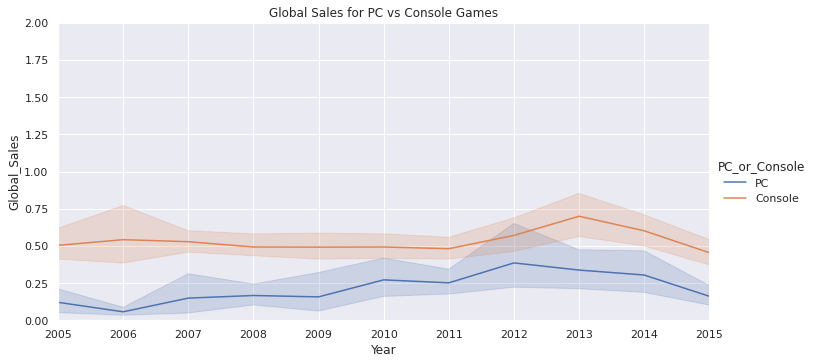

In [ ]:
ticks=[2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
pc_vs_console_year_line=sns.relplot(x='Year', y="Global_Sales", data=pc_or_console, hue='PC_or_Console', kind='line',aspect=10/5).set(title='Global Sales for PC vs Console Games')
plt.xlim(2005,2015)
plt.xticks(ticks)
plt.ylim(0,2)
ax.set(ylabel="Global Sales (millions)")

[Text(0, 0.5, 'Count of Games Made for Each Platform')]

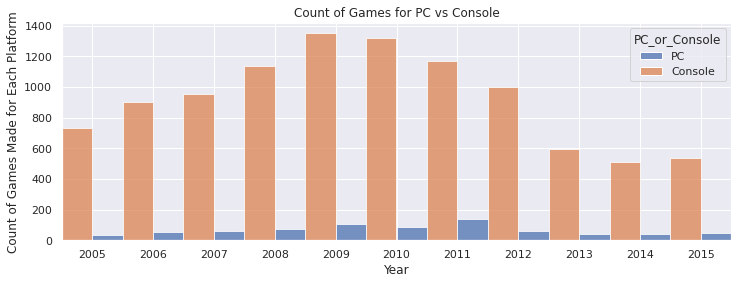

In [ ]:
ax.set(ylabel="Global Sales (millions)")
f, ax = plt.subplots(figsize=(12, 4))
pc_vs_console_year_hist=sns.histplot(x="Year", hue="PC_or_Console", binwidth=1, multiple="dodge", data=pc_or_console).set(title='Count of Games for PC vs Console')
plt.xlim(2004.5,2015.5)
plt.xticks(ticks)
#pc_vs_console_year_hist.set_xticklabels(["1-25", "25-45", "45-55", "55-80"])
ax.set(ylabel="Count of Games Made for Each Platform")

We can see a definite dip approaching the end of the dataset, which we can attribute, again, to vgchartz's difficulty in estimating digital sales. That being said, the trends we noticed in our 2005-2015 range still hold. Interestingly, we can see from the histogram that there are a vastly larger number of different console games being sold, which tells us there isn't as much variety in the PC gaming world (and that games in the PC world quite possibly have greater individual sales, which could be a matter of price or of volume - something beyond the scope of this analysis).

# Conclusion and Recommendations

This analysis was a great learning experience, in terms of starting at the very beginning of understanding where a dataset comes from, the difficulties of organizing and creating the dataset, as well as the actual analysis. We pulled out some interesting trends in terms of year-to-year sales, genre, and platform, which would prove useful to executives trying to make decisions for their game companies. Based on this data, I would urge companies to explore the possibility of increasing the games released for PC, as we see there is a dearth of variety in PC games even though the platform itself is robust and versatile. (And, indeed, in 2021 and 2022 more publishers have begun to release games for the PC!) I also would urge publishers to share more of their real-world sales data for the benefit of consumers and all companies, as projecting analysis these days can be extremely difficult without physical sales to track. I would be curious to integrate more complete data from 2018-present into this dataset, but for now these results will stand on their own.

One final note: I assigned discrete variables to most of the graphs and t-test results of this report. The intention is to format this Python project in such a way to produce a completed document, for use in non-Jupyter formats. I intend to implement this feature when I share a version of this project on Git, but I am not including it in this version.